In [64]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

In [65]:
# Arizona 7 consists of Pima, Maricopa and Yuma counties
# YEAR 2024
# Pima County
age_under_18_pima = 0.193
non_citizens_pima = 0.122
mental_issue_pima = 0.17
population_pima = 1068848

eligible_voters_pima = population_pima * (1 - non_citizens_pima) * (1 - age_under_18_pima) * (1 - mental_issue_pima)
print(f"Number of voters eligible for Pima County, Arizona 7: {round(eligible_voters_pima)}")

# Maricopa County
age_under_18_maricopa = 0.27
non_citizens_maricopa = 0.147
mental_issue_maricopa = 0.19
population_maricopa = 4585871

eligible_voters_maricopa = population_pima * (1 - non_citizens_maricopa) * (1 - age_under_18_maricopa) * (1 - mental_issue_maricopa)
print(f"Number of voters eligible for Maricopa County, Arizona 7: {round(eligible_voters_maricopa)}")

# Yuma County
age_under_18_yuma = 0.222
non_citizens_yuma = 0.247
mental_issue_yuma = 0.25
population_yuma = 213221

eligible_voters_yuma = population_pima * (1 - non_citizens_yuma) * (1 - age_under_18_yuma) * (1 - mental_issue_yuma)
print(f"Number of voters eligible for Yuma County, Arizona 7: {round(eligible_voters_yuma)}")

Number of voters eligible for Pima County, Arizona 7: 628582
Number of voters eligible for Maricopa County, Arizona 7: 539104
Number of voters eligible for Yuma County, Arizona 7: 469626


In [66]:
election = pd.read_excel('Ballot_AZ7.xlsx')
election.head()

,County,Election,Year,Eligible Voters,Ballots
0,Pima,Primary,2024,628582,197226
1,Pima,Consolidated,2023,628582,132402
2,Pima,General,2022,637671,331304
3,Pima,Primary,2022,637671,398315
4,Pima,General,2021,624809,16710


In [67]:
# Feature Engineering
election['Turnout_pct'] = (election['Ballots'] / election['Eligible Voters']) * 100
election['Election'] = election['Election'].map({'General': 1, 'Consolidated': 2, 'Primary': 0}).astype('category')
# Normalize County Names
election['County'] = election['County'].str.strip().str.title()


In [68]:
election.isnull().sum()

County             0
Election           0
Year               0
Eligible Voters    0
Ballots            0
Turnout_pct        0
dtype: int64

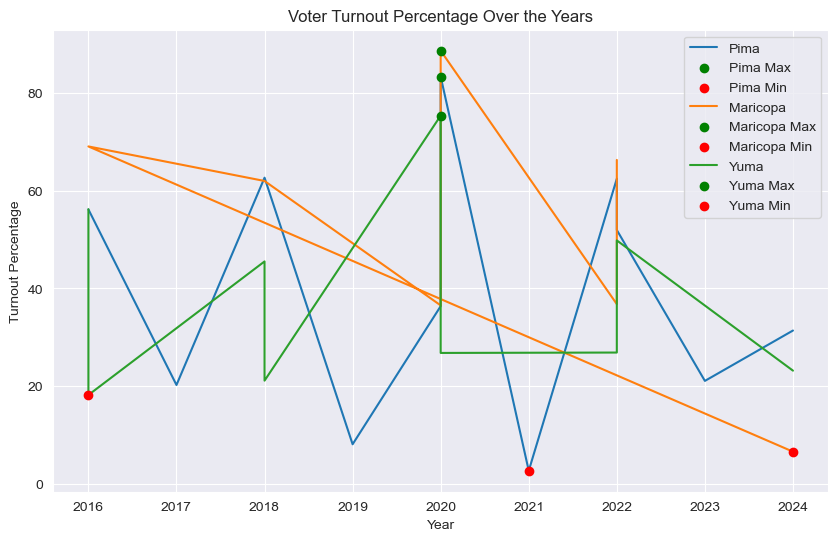

In [69]:
# Visualization
plt.figure(figsize=(10, 6))

for county in election['County'].unique():
    subset = election[election['County'] == county]

    plt.plot(subset['Year'], subset['Turnout_pct'], label=county)
    max_point = subset.loc[subset['Turnout_pct'].idxmax()]
    plt.scatter(max_point['Year'], max_point['Turnout_pct'], color='green', label=f'{county} Max', zorder=5)

    min_point = subset.loc[subset['Turnout_pct'].idxmin()]
    plt.scatter(min_point['Year'], min_point['Turnout_pct'], color='red', label=f'{county} Min', zorder=5)


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.title("Voter Turnout Percentage Over the Years")
plt.xlabel("Year")
plt.ylabel("Turnout Percentage")
plt.show()


In [70]:
models = {'Linear Regression': LinearRegression(),
          'Random Forest': RandomForestRegressor(random_state=42),
          'Decision Tree': DecisionTreeRegressor(random_state=42),
          'Gradient Boosting': GradientBoostingRegressor(random_state=42),
          'Support Vector Machine': SVR(kernel='rbf', C=1.0, gamma=0.1)
          }

In [71]:
election[election["Election"] == 1] # General

,County,Election,Year,Eligible Voters,Ballots,Turnout_pct
2,Pima,1,2022,637671,331304,51.955319
4,Pima,1,2021,624809,16710,2.674417
5,Pima,1,2020,631462,526319,83.349275
8,Pima,1,2018,627681,393352,62.667501
10,Pima,1,2016,614934,345424,56.172532
11,Maricopa,1,2022,2357115,1562758,66.299608
13,Maricopa,1,2020,2356748,2089563,88.662980
15,Maricopa,1,2018,2382235,1476835,61.993674
16,Maricopa,1,2016,2329435,1608875,69.067177
18,Yuma,1,2022,93988,46830,49.825510


In [72]:
election_general = election[election["Election"] == 1] # General

results = []

def train_and_predict(data, county_name, models):
    X = data[['Year', 'Election', 'Eligible Voters']]
    y = data['Ballots']

    X_test = data[(data['County'] == county_name)][['Year', 'Election', 'Eligible Voters']]

    if X_test.empty:
        print(f"Warning: No data found for {county_name} in 2024")
        return

    for model_name, model in models.items():
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

        model.fit(X_train, y_train)

        y_val_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_val_pred)
        r2 = r2_score(y_val, y_val_pred)

        y_pred = model.predict(X_test)

        eligible_voters = X_test['Eligible Voters'].values[0]
        pred_ballots = min(y_pred[0], eligible_voters)
        turnout_pct = float((pred_ballots / eligible_voters) * 100)

        results.append({
            'County': county_name,
            'Model': model_name,
            'Predicted_Ballots': round(pred_ballots),
            'Eligible_Voters': eligible_voters,
            'Turnout_Percentage': round(turnout_pct, 2),
            'MSE': round(mse, 2),
            'R2': round(r2, 2)
        })



In [73]:
for county in election['County'].unique():
    train_and_predict(election_general, county, models)

results_df = pd.DataFrame(results)

print("Predicted Ballots and Turnout Percentage for 2024 General Elections by Model:")

Predicted Ballots and Turnout Percentage for 2024 General Elections by Model:


In [74]:
print(results_df[['County', 'Model', 'Predicted_Ballots', 'Eligible_Voters', 'Turnout_Percentage', 'MSE', 'R2']].to_string(index=False))

  County                  Model  Predicted_Ballots  Eligible_Voters  Turnout_Percentage          MSE     R2
    Pima      Linear Regression             637671           637671              100.00 3.952916e+11 -20.79
    Pima          Random Forest             379495           637671               59.51 6.304271e+09   0.65
    Pima          Decision Tree             526319           637671               82.54 1.300975e+10   0.28
    Pima      Gradient Boosting             354640           637671               55.61 2.078446e+08   0.99
    Pima Support Vector Machine             526319           637671               82.54 1.667410e+11  -8.19
Maricopa      Linear Regression             862788          2357115               36.60 3.952916e+11 -20.79
Maricopa          Random Forest            1728370          2357115               73.33 6.304271e+09   0.65
Maricopa          Decision Tree            1562758          2357115               66.30 1.300975e+10   0.28
Maricopa      Gradient Boost

In [75]:
az7 = ['Pima', 'Maricopa', 'Yuma']
results_df = results_df[results_df['County'].isin(az7)]

results = results_df.groupby('Model').apply(lambda group: pd.Series({
    'Total_Predicted_Ballots': group['Predicted_Ballots'].sum(),
    'Total_Eligible_Voters': group['Eligible_Voters'].sum(),
    'Turnout_Percentage': (group['Predicted_Ballots'].sum() / group['Eligible_Voters'].sum()) * 100
}))

print(results)

                        Total_Predicted_Ballots  Total_Eligible_Voters  \
Model                                                                    
Decision Tree                         2105787.0              3088774.0   
Gradient Boosting                     1973222.0              3088774.0   
Linear Regression                     1594447.0              3088774.0   
Random Forest                         2201853.0              3088774.0   
Support Vector Machine                1146627.0              3088774.0   

                        Turnout_Percentage  
Model                                       
Decision Tree                    68.175496  
Gradient Boosting                63.883664  
Linear Regression                51.620708  
Random Forest                    71.285662  
Support Vector Machine           37.122399  


/var/folders/mr/fkq_2qln42x5d_t45c7dz0fr0000gn/T/ipykernel_83439/338088103.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=results_df, x='Model', y='Predicted_Ballots', hue='County', ci=None)


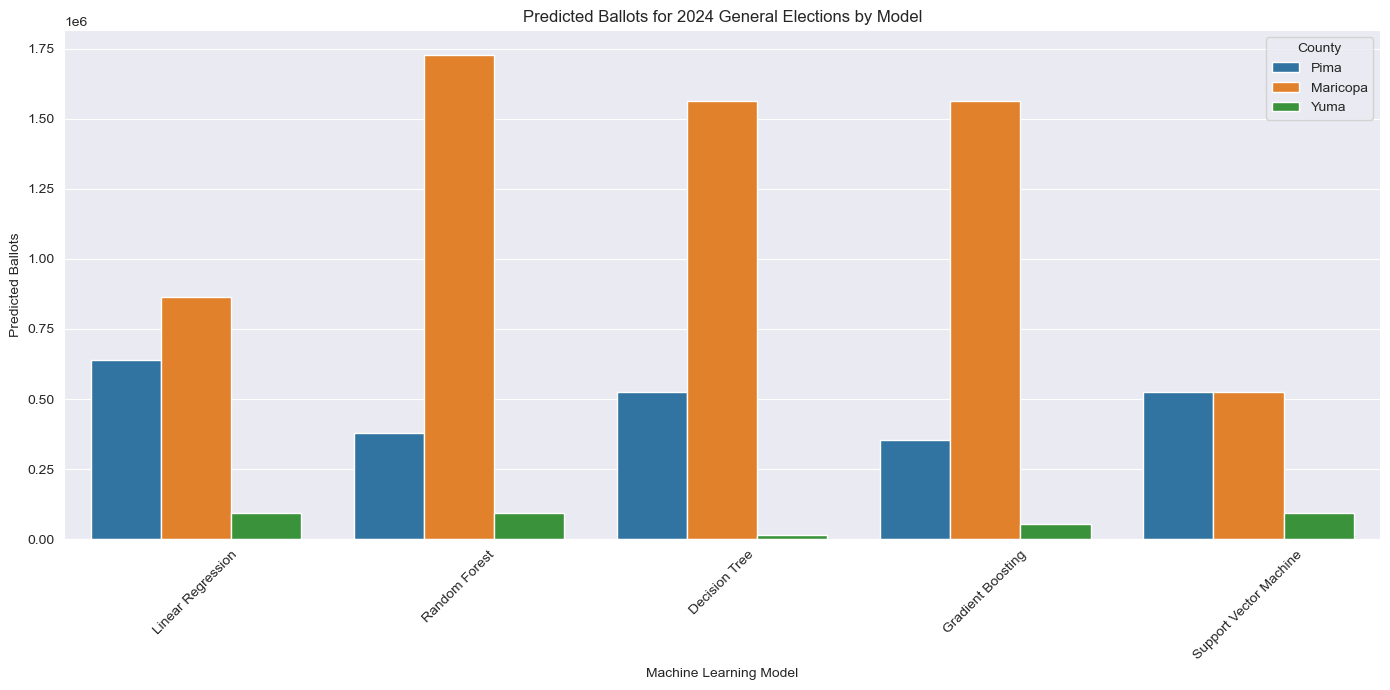

/var/folders/mr/fkq_2qln42x5d_t45c7dz0fr0000gn/T/ipykernel_83439/338088103.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=results_df, x='Model', y='Turnout_Percentage', hue='County', ci=None)


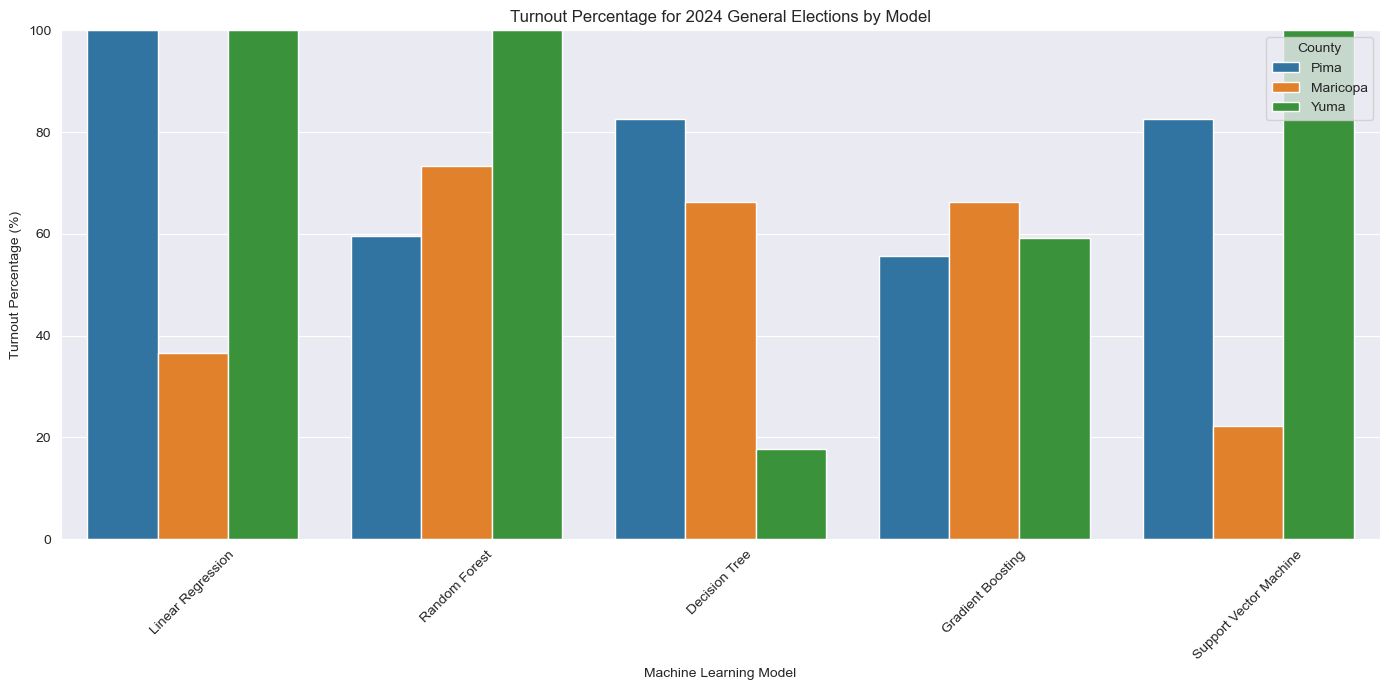

/var/folders/mr/fkq_2qln42x5d_t45c7dz0fr0000gn/T/ipykernel_83439/338088103.py:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=results_df, x='Model', y='MSE', hue='County', ci=None, ax=axes[0])
/var/folders/mr/fkq_2qln42x5d_t45c7dz0fr0000gn/T/ipykernel_83439/338088103.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=results_df, x='Model', y='R2', hue='County', ci=None, ax=axes[1])


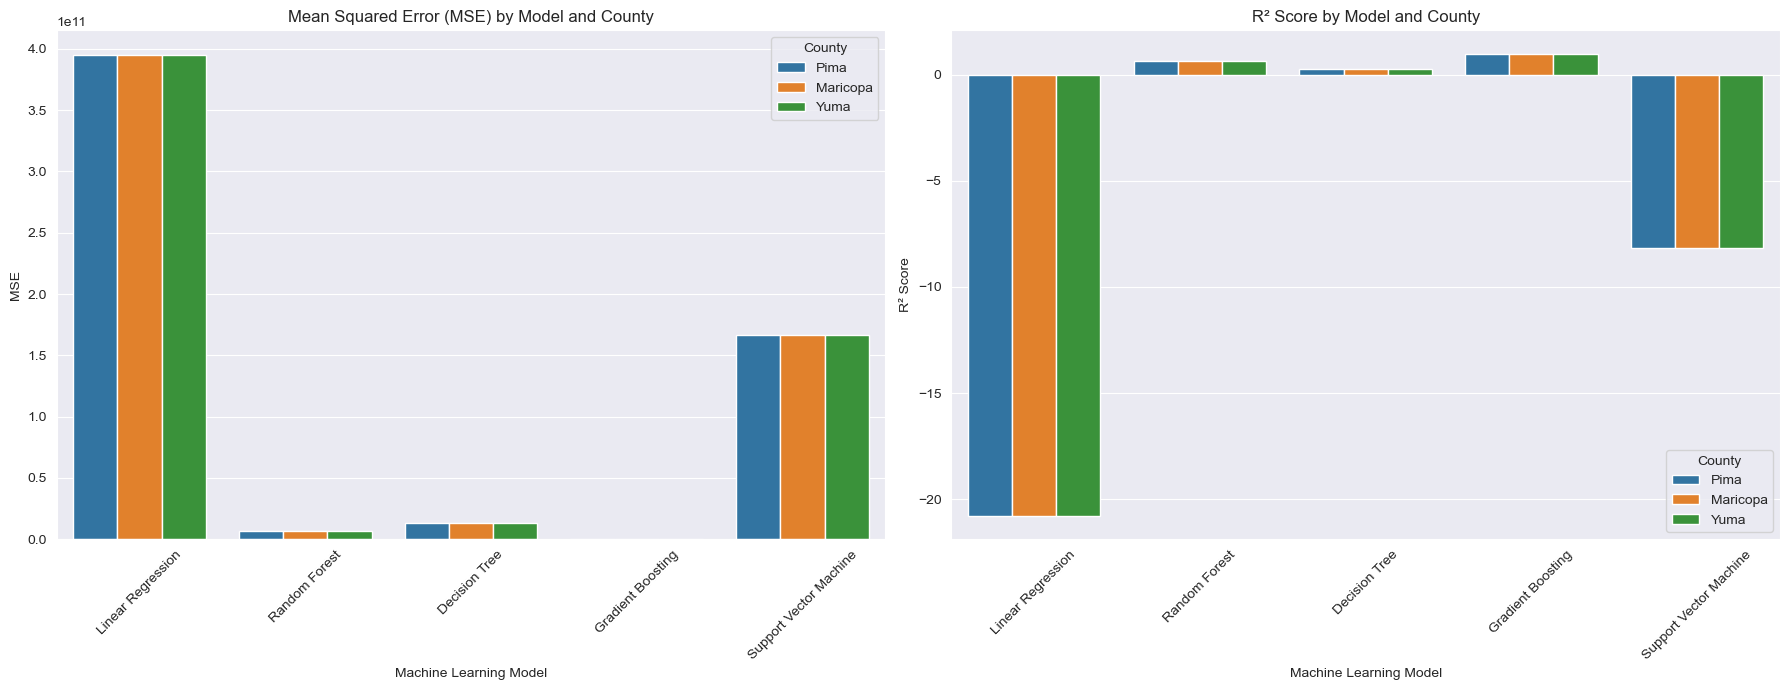

In [76]:
# Predicted Ballots
plt.figure(figsize=(14, 7))
sns.barplot(data=results_df, x='Model', y='Predicted_Ballots', hue='County', ci=None)
plt.title("Predicted Ballots for 2024 General Elections by Model")
plt.xlabel("Machine Learning Model")
plt.ylabel("Predicted Ballots")
plt.xticks(rotation=45)
plt.legend(title="County")
plt.tight_layout()
plt.show()

# Turnout Percentage
plt.figure(figsize=(14, 7))
sns.barplot(data=results_df, x='Model', y='Turnout_Percentage', hue='County', ci=None)
plt.title("Turnout Percentage for 2024 General Elections by Model")
plt.xlabel("Machine Learning Model")
plt.ylabel("Turnout Percentage (%)")
plt.xticks(rotation=45)
plt.legend(title="County")
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

# MSE and R² Comparison
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# MSE Plot
sns.barplot(data=results_df, x='Model', y='MSE', hue='County', ci=None, ax=axes[0])
axes[0].set_title("Mean Squared Error (MSE) by Model and County")
axes[0].set_xlabel("Machine Learning Model")
axes[0].set_ylabel("MSE")
axes[0].tick_params(axis='x', rotation=45)

# R² Plot
sns.barplot(data=results_df, x='Model', y='R2', hue='County', ci=None, ax=axes[1])
axes[1].set_title("R² Score by Model and County")
axes[1].set_xlabel("Machine Learning Model")
axes[1].set_ylabel("R² Score")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
